Additionally to the novel DoB-CLEAN algorithm presented in tutorial 10, we also have an implementation of standard CLEAN. The syntax is exactly the same, so let us reproduce the first steps of tutorial 10.

In [1]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt

from imagingbase.ehtim_wrapper import EhtimWrapper
from imagingbase.solvers.clean_handler import CLEAN

import pathlib 
current_path = str(pathlib.Path().absolute())

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

Welcome to eht-imaging! v 1.2.4 



In [2]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'fast'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 1.0                 # Total compact flux density (Jy)
npix      = 1024                 # Number of pixels across the reconstructed image
fov       = 10**6*eh.RADPERUAS    # Field of view of the reconstructed image

Loading uvfits:  /homes/hmueller/mr_beam/synthesis_regpy/examples/../synthetic_data/gaussian_ellipse_obs.fits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  /homes/hmueller/mr_beam/synthesis_regpy/examples/../synthetic_data/gaussian_ellipse.fits


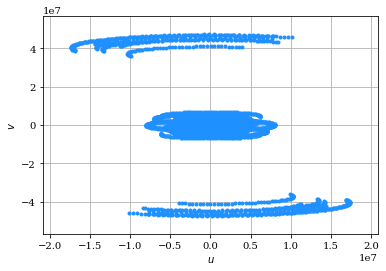

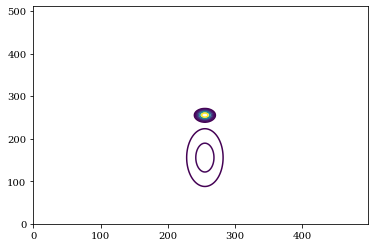

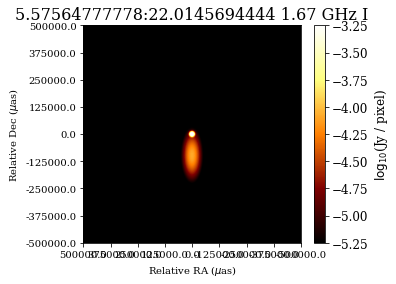

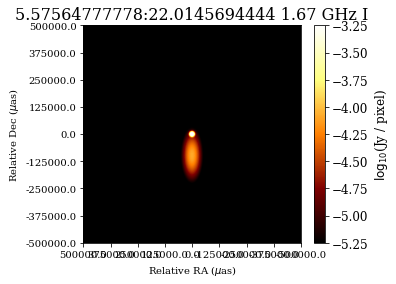

In [3]:
obs_sc = eh.obsdata.load_uvfits(current_path+r'/../synthetic_data/gaussian_ellipse_obs.fits')
img = eh.image.load_fits(current_path+r'/../synthetic_data/gaussian_ellipse.fits')

obs_sc.plotall('u', 'v', conj=True)

peak = np.max(img.imarr())
levels = np.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64])
plt.contour(img.imarr()[256:768,256:756][::-1], levels=peak*levels)
plt.show()

img.display(scale='log', cbar_lims=[-5.25, -3.25])

In [4]:
psf_fwhm1 = 0.01779*eh.RADPERAS
psf_fwhm2 = 0.004309*eh.RADPERAS
angle = -np.pi/180*8.73

psfprior = eh.image.make_square(obs_sc, npix//4, fov)
psfprior = psfprior.add_gauss(1, (psf_fwhm1, psf_fwhm2, angle, 0, 0))

In [5]:
psfprior = psfprior.regrid_image(fov, npix+1)

wrapper = EhtimWrapper(obs_sc.copy(), psfprior, psfprior, zbl, d='vis', ttype=ttype, clipfloor=-100, num_cores=16)
widths = wrapper.find_widths(5*10**6, fov=0.2)

Generating I image...


In [6]:
dmap = np.load(current_path+r'/../synthetic_data/dmap.npy')
dbeam = np.load(current_path+r'/../synthetic_data/dbeam.npy')

Now we define the CLEAN solver instance. We just have to replace the 'Hybrid' keyword with 'Hogbom'. The initialization is much faster now since CLEAN is not multiscalar and we do have to precompute the large wavelet transform matrices and cross-terms. 

In [7]:
solver = CLEAN(wrapper, 'Hogbom', widths, psf_from_prior=True, sdmap=dmap, sdbeam=dbeam)

2022-08-04 17:38:52,904 INFO CLEAN                :: Initialize solver ...
2022-08-04 17:38:52,906 INFO CLEAN                :: Initialize dirty beam and dirty map ...
2022-08-04 17:38:52,988 INFO CLEAN                :: Finalize initialization ...


The precomputation is the same as before.

In [8]:
bounds = np.array([npix//4, 3*npix//4, npix//4, 3*npix//4], dtype=int)
#bounds = np.array([npix//8*3, 5*npix//8, npix//8*3, 5*npix//8], dtype=int)

dictionary = {
    "weights" : np.ones(len(widths), dtype=float),
    "gain" : 0.2,
    "limits" : bounds
}

solver.set_bounds_from_script(bounds)
solver.precompute_from_dictionary(dictionary)

solver.update_levels(np.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64]))

2022-08-04 17:38:55,403 INFO CLEAN                :: Specify Plotting Bounds
2022-08-04 17:38:55,405 INFO CLEAN                :: [256 768 256 768]


We can update any of these parameters anytime during the cleaning (works also for 'Hybrid', 'Bessel' and 'DoG'), e.g. ...

In [9]:
solver.update_gain(0.1)

2022-08-04 17:38:57,748 INFO CLEAN                :: Update gain
2022-08-04 17:38:57,750 INFO CLEAN                :: 0.1


Run minimization and inspect result.

2022-08-04 17:39:06,000 INFO CLEAN                :: Start running CLEAN with 1000 iterations
2022-08-04 17:39:06,225 INFO CountIterations      :: iteration = 1 / 1000
2022-08-04 17:39:06,353 INFO CountIterations      :: iteration = 2 / 1000
2022-08-04 17:39:06,495 INFO CountIterations      :: iteration = 3 / 1000
2022-08-04 17:39:06,621 INFO CountIterations      :: iteration = 4 / 1000
2022-08-04 17:39:06,764 INFO CountIterations      :: iteration = 5 / 1000
2022-08-04 17:39:06,890 INFO CountIterations      :: iteration = 6 / 1000
2022-08-04 17:39:07,031 INFO CountIterations      :: iteration = 7 / 1000
2022-08-04 17:39:07,153 INFO CountIterations      :: iteration = 8 / 1000
2022-08-04 17:39:07,290 INFO CountIterations      :: iteration = 9 / 1000
2022-08-04 17:39:07,412 INFO CountIterations      :: iteration = 10 / 1000
2022-08-04 17:39:07,557 INFO CountIterations      :: iteration = 11 / 1000
2022-08-04 17:39:07,685 INFO CountIterations      :: iteration = 12 / 1000
2022-08-04 17:3

2114.5568343503046 cleaned at iteration  50
rms 3.3857645369849116e-07


2022-08-04 17:39:12,729 INFO CountIterations      :: iteration = 52 / 1000
2022-08-04 17:39:12,860 INFO CountIterations      :: iteration = 53 / 1000
2022-08-04 17:39:12,981 INFO CountIterations      :: iteration = 54 / 1000
2022-08-04 17:39:13,108 INFO CountIterations      :: iteration = 55 / 1000
2022-08-04 17:39:13,226 INFO CountIterations      :: iteration = 56 / 1000
2022-08-04 17:39:13,363 INFO CountIterations      :: iteration = 57 / 1000
2022-08-04 17:39:13,479 INFO CountIterations      :: iteration = 58 / 1000
2022-08-04 17:39:13,612 INFO CountIterations      :: iteration = 59 / 1000
2022-08-04 17:39:13,725 INFO CountIterations      :: iteration = 60 / 1000
2022-08-04 17:39:13,860 INFO CountIterations      :: iteration = 61 / 1000
2022-08-04 17:39:13,974 INFO CountIterations      :: iteration = 62 / 1000
2022-08-04 17:39:14,102 INFO CountIterations      :: iteration = 63 / 1000
2022-08-04 17:39:14,223 INFO CountIterations      :: iteration = 64 / 1000
2022-08-04 17:39:14,349 I

2114.6729704097365 cleaned at iteration  100
rms 2.0760382011650506e-07


2022-08-04 17:39:18,888 INFO CountIterations      :: iteration = 102 / 1000
2022-08-04 17:39:19,019 INFO CountIterations      :: iteration = 103 / 1000
2022-08-04 17:39:19,139 INFO CountIterations      :: iteration = 104 / 1000
2022-08-04 17:39:19,270 INFO CountIterations      :: iteration = 105 / 1000
2022-08-04 17:39:19,380 INFO CountIterations      :: iteration = 106 / 1000
2022-08-04 17:39:19,508 INFO CountIterations      :: iteration = 107 / 1000
2022-08-04 17:39:19,620 INFO CountIterations      :: iteration = 108 / 1000
2022-08-04 17:39:19,753 INFO CountIterations      :: iteration = 109 / 1000
2022-08-04 17:39:19,862 INFO CountIterations      :: iteration = 110 / 1000
2022-08-04 17:39:19,991 INFO CountIterations      :: iteration = 111 / 1000
2022-08-04 17:39:20,112 INFO CountIterations      :: iteration = 112 / 1000
2022-08-04 17:39:20,243 INFO CountIterations      :: iteration = 113 / 1000
2022-08-04 17:39:20,354 INFO CountIterations      :: iteration = 114 / 1000
2022-08-04 1

2114.741310943692 cleaned at iteration  150
rms 1.3027544173495114e-07


2022-08-04 17:39:25,015 INFO CountIterations      :: iteration = 152 / 1000
2022-08-04 17:39:25,150 INFO CountIterations      :: iteration = 153 / 1000
2022-08-04 17:39:25,258 INFO CountIterations      :: iteration = 154 / 1000
2022-08-04 17:39:25,391 INFO CountIterations      :: iteration = 155 / 1000
2022-08-04 17:39:25,510 INFO CountIterations      :: iteration = 156 / 1000
2022-08-04 17:39:25,646 INFO CountIterations      :: iteration = 157 / 1000
2022-08-04 17:39:25,761 INFO CountIterations      :: iteration = 158 / 1000
2022-08-04 17:39:25,887 INFO CountIterations      :: iteration = 159 / 1000
2022-08-04 17:39:25,999 INFO CountIterations      :: iteration = 160 / 1000
2022-08-04 17:39:26,131 INFO CountIterations      :: iteration = 161 / 1000
2022-08-04 17:39:26,239 INFO CountIterations      :: iteration = 162 / 1000
2022-08-04 17:39:26,370 INFO CountIterations      :: iteration = 163 / 1000
2022-08-04 17:39:26,483 INFO CountIterations      :: iteration = 164 / 1000
2022-08-04 1

2114.7832696612363 cleaned at iteration  200
rms 8.329389512180083e-08


2022-08-04 17:39:31,111 INFO CountIterations      :: iteration = 202 / 1000
2022-08-04 17:39:31,243 INFO CountIterations      :: iteration = 203 / 1000
2022-08-04 17:39:31,360 INFO CountIterations      :: iteration = 204 / 1000
2022-08-04 17:39:31,486 INFO CountIterations      :: iteration = 205 / 1000
2022-08-04 17:39:31,602 INFO CountIterations      :: iteration = 206 / 1000
2022-08-04 17:39:31,728 INFO CountIterations      :: iteration = 207 / 1000
2022-08-04 17:39:31,837 INFO CountIterations      :: iteration = 208 / 1000
2022-08-04 17:39:31,959 INFO CountIterations      :: iteration = 209 / 1000
2022-08-04 17:39:32,072 INFO CountIterations      :: iteration = 210 / 1000
2022-08-04 17:39:32,193 INFO CountIterations      :: iteration = 211 / 1000
2022-08-04 17:39:32,304 INFO CountIterations      :: iteration = 212 / 1000
2022-08-04 17:39:32,435 INFO CountIterations      :: iteration = 213 / 1000
2022-08-04 17:39:32,550 INFO CountIterations      :: iteration = 214 / 1000
2022-08-04 1

2114.8095237841876 cleaned at iteration  250
rms 5.477734024635991e-08


2022-08-04 17:39:37,182 INFO CountIterations      :: iteration = 252 / 1000
2022-08-04 17:39:37,309 INFO CountIterations      :: iteration = 253 / 1000
2022-08-04 17:39:37,429 INFO CountIterations      :: iteration = 254 / 1000
2022-08-04 17:39:37,557 INFO CountIterations      :: iteration = 255 / 1000
2022-08-04 17:39:37,670 INFO CountIterations      :: iteration = 256 / 1000
2022-08-04 17:39:37,802 INFO CountIterations      :: iteration = 257 / 1000
2022-08-04 17:39:37,909 INFO CountIterations      :: iteration = 258 / 1000
2022-08-04 17:39:38,042 INFO CountIterations      :: iteration = 259 / 1000
2022-08-04 17:39:38,162 INFO CountIterations      :: iteration = 260 / 1000
2022-08-04 17:39:38,292 INFO CountIterations      :: iteration = 261 / 1000
2022-08-04 17:39:38,400 INFO CountIterations      :: iteration = 262 / 1000
2022-08-04 17:39:38,532 INFO CountIterations      :: iteration = 263 / 1000
2022-08-04 17:39:38,642 INFO CountIterations      :: iteration = 264 / 1000
2022-08-04 1

2114.826145525167 cleaned at iteration  300
rms 3.7313906821444276e-08


2022-08-04 17:39:43,234 INFO CountIterations      :: iteration = 302 / 1000
2022-08-04 17:39:43,357 INFO CountIterations      :: iteration = 303 / 1000
2022-08-04 17:39:43,467 INFO CountIterations      :: iteration = 304 / 1000
2022-08-04 17:39:43,596 INFO CountIterations      :: iteration = 305 / 1000
2022-08-04 17:39:43,717 INFO CountIterations      :: iteration = 306 / 1000
2022-08-04 17:39:43,840 INFO CountIterations      :: iteration = 307 / 1000
2022-08-04 17:39:43,957 INFO CountIterations      :: iteration = 308 / 1000
2022-08-04 17:39:44,082 INFO CountIterations      :: iteration = 309 / 1000
2022-08-04 17:39:44,194 INFO CountIterations      :: iteration = 310 / 1000
2022-08-04 17:39:44,324 INFO CountIterations      :: iteration = 311 / 1000
2022-08-04 17:39:44,437 INFO CountIterations      :: iteration = 312 / 1000
2022-08-04 17:39:44,561 INFO CountIterations      :: iteration = 313 / 1000
2022-08-04 17:39:44,667 INFO CountIterations      :: iteration = 314 / 1000
2022-08-04 1

2114.8368154313325 cleaned at iteration  350
rms 2.667824558238519e-08


2022-08-04 17:39:49,250 INFO CountIterations      :: iteration = 352 / 1000
2022-08-04 17:39:49,377 INFO CountIterations      :: iteration = 353 / 1000
2022-08-04 17:39:49,492 INFO CountIterations      :: iteration = 354 / 1000
2022-08-04 17:39:49,620 INFO CountIterations      :: iteration = 355 / 1000
2022-08-04 17:39:49,733 INFO CountIterations      :: iteration = 356 / 1000
2022-08-04 17:39:49,863 INFO CountIterations      :: iteration = 357 / 1000
2022-08-04 17:39:49,970 INFO CountIterations      :: iteration = 358 / 1000
2022-08-04 17:39:50,093 INFO CountIterations      :: iteration = 359 / 1000
2022-08-04 17:39:50,208 INFO CountIterations      :: iteration = 360 / 1000
2022-08-04 17:39:50,335 INFO CountIterations      :: iteration = 361 / 1000
2022-08-04 17:39:50,444 INFO CountIterations      :: iteration = 362 / 1000
2022-08-04 17:39:50,565 INFO CountIterations      :: iteration = 363 / 1000
2022-08-04 17:39:50,683 INFO CountIterations      :: iteration = 364 / 1000
2022-08-04 1

2114.8435671042585 cleaned at iteration  400
rms 2.0696352769801752e-08


2022-08-04 17:39:55,158 INFO CountIterations      :: iteration = 402 / 1000
2022-08-04 17:39:55,266 INFO CountIterations      :: iteration = 403 / 1000
2022-08-04 17:39:55,374 INFO CountIterations      :: iteration = 404 / 1000
2022-08-04 17:39:55,496 INFO CountIterations      :: iteration = 405 / 1000
2022-08-04 17:39:55,593 INFO CountIterations      :: iteration = 406 / 1000
2022-08-04 17:39:55,728 INFO CountIterations      :: iteration = 407 / 1000
2022-08-04 17:39:55,845 INFO CountIterations      :: iteration = 408 / 1000
2022-08-04 17:39:55,966 INFO CountIterations      :: iteration = 409 / 1000
2022-08-04 17:39:56,086 INFO CountIterations      :: iteration = 410 / 1000
2022-08-04 17:39:56,216 INFO CountIterations      :: iteration = 411 / 1000
2022-08-04 17:39:56,329 INFO CountIterations      :: iteration = 412 / 1000
2022-08-04 17:39:56,459 INFO CountIterations      :: iteration = 413 / 1000
2022-08-04 17:39:56,576 INFO CountIterations      :: iteration = 414 / 1000
2022-08-04 1

2114.8463791117556 cleaned at iteration  450
rms 1.649835967710434e-08


2022-08-04 17:40:00,905 INFO CountIterations      :: iteration = 452 / 1000
2022-08-04 17:40:01,032 INFO CountIterations      :: iteration = 453 / 1000
2022-08-04 17:40:01,130 INFO CountIterations      :: iteration = 454 / 1000
2022-08-04 17:40:01,250 INFO CountIterations      :: iteration = 455 / 1000
2022-08-04 17:40:01,350 INFO CountIterations      :: iteration = 456 / 1000
2022-08-04 17:40:01,463 INFO CountIterations      :: iteration = 457 / 1000
2022-08-04 17:40:01,568 INFO CountIterations      :: iteration = 458 / 1000
2022-08-04 17:40:01,701 INFO CountIterations      :: iteration = 459 / 1000
2022-08-04 17:40:01,808 INFO CountIterations      :: iteration = 460 / 1000
2022-08-04 17:40:01,935 INFO CountIterations      :: iteration = 461 / 1000
2022-08-04 17:40:02,052 INFO CountIterations      :: iteration = 462 / 1000
2022-08-04 17:40:02,162 INFO CountIterations      :: iteration = 463 / 1000
2022-08-04 17:40:02,259 INFO CountIterations      :: iteration = 464 / 1000
2022-08-04 1

2114.8479370393875 cleaned at iteration  500
rms 1.3949283287510149e-08


2022-08-04 17:40:06,525 INFO CountIterations      :: iteration = 502 / 1000
2022-08-04 17:40:06,632 INFO CountIterations      :: iteration = 503 / 1000
2022-08-04 17:40:06,735 INFO CountIterations      :: iteration = 504 / 1000
2022-08-04 17:40:06,846 INFO CountIterations      :: iteration = 505 / 1000
2022-08-04 17:40:06,951 INFO CountIterations      :: iteration = 506 / 1000
2022-08-04 17:40:07,071 INFO CountIterations      :: iteration = 507 / 1000
2022-08-04 17:40:07,170 INFO CountIterations      :: iteration = 508 / 1000
2022-08-04 17:40:07,286 INFO CountIterations      :: iteration = 509 / 1000
2022-08-04 17:40:07,402 INFO CountIterations      :: iteration = 510 / 1000
2022-08-04 17:40:07,515 INFO CountIterations      :: iteration = 511 / 1000
2022-08-04 17:40:07,612 INFO CountIterations      :: iteration = 512 / 1000
2022-08-04 17:40:07,723 INFO CountIterations      :: iteration = 513 / 1000
2022-08-04 17:40:07,831 INFO CountIterations      :: iteration = 514 / 1000
2022-08-04 1

2114.848715606878 cleaned at iteration  550
rms 1.1993617818439401e-08


2022-08-04 17:40:12,082 INFO CountIterations      :: iteration = 552 / 1000
2022-08-04 17:40:12,196 INFO CountIterations      :: iteration = 553 / 1000
2022-08-04 17:40:12,293 INFO CountIterations      :: iteration = 554 / 1000
2022-08-04 17:40:12,407 INFO CountIterations      :: iteration = 555 / 1000
2022-08-04 17:40:12,508 INFO CountIterations      :: iteration = 556 / 1000
2022-08-04 17:40:12,621 INFO CountIterations      :: iteration = 557 / 1000
2022-08-04 17:40:12,724 INFO CountIterations      :: iteration = 558 / 1000
2022-08-04 17:40:12,844 INFO CountIterations      :: iteration = 559 / 1000
2022-08-04 17:40:12,959 INFO CountIterations      :: iteration = 560 / 1000
2022-08-04 17:40:13,094 INFO CountIterations      :: iteration = 561 / 1000
2022-08-04 17:40:13,193 INFO CountIterations      :: iteration = 562 / 1000
2022-08-04 17:40:13,307 INFO CountIterations      :: iteration = 563 / 1000
2022-08-04 17:40:13,405 INFO CountIterations      :: iteration = 564 / 1000
2022-08-04 1

2114.849394212397 cleaned at iteration  600
rms 1.0642545942453118e-08


2022-08-04 17:40:17,632 INFO CountIterations      :: iteration = 602 / 1000
2022-08-04 17:40:17,752 INFO CountIterations      :: iteration = 603 / 1000
2022-08-04 17:40:17,848 INFO CountIterations      :: iteration = 604 / 1000
2022-08-04 17:40:17,959 INFO CountIterations      :: iteration = 605 / 1000
2022-08-04 17:40:18,073 INFO CountIterations      :: iteration = 606 / 1000
2022-08-04 17:40:18,189 INFO CountIterations      :: iteration = 607 / 1000
2022-08-04 17:40:18,302 INFO CountIterations      :: iteration = 608 / 1000
2022-08-04 17:40:18,418 INFO CountIterations      :: iteration = 609 / 1000
2022-08-04 17:40:18,584 INFO CountIterations      :: iteration = 610 / 1000
2022-08-04 17:40:18,708 INFO CountIterations      :: iteration = 611 / 1000
2022-08-04 17:40:18,821 INFO CountIterations      :: iteration = 612 / 1000
2022-08-04 17:40:18,942 INFO CountIterations      :: iteration = 613 / 1000
2022-08-04 17:40:19,059 INFO CountIterations      :: iteration = 614 / 1000
2022-08-04 1

2114.8499920578474 cleaned at iteration  650
rms 9.575416700131676e-09


2022-08-04 17:40:23,240 INFO CountIterations      :: iteration = 652 / 1000
2022-08-04 17:40:23,371 INFO CountIterations      :: iteration = 653 / 1000
2022-08-04 17:40:23,477 INFO CountIterations      :: iteration = 654 / 1000
2022-08-04 17:40:23,604 INFO CountIterations      :: iteration = 655 / 1000
2022-08-04 17:40:23,702 INFO CountIterations      :: iteration = 656 / 1000
2022-08-04 17:40:23,822 INFO CountIterations      :: iteration = 657 / 1000
2022-08-04 17:40:23,923 INFO CountIterations      :: iteration = 658 / 1000
2022-08-04 17:40:24,037 INFO CountIterations      :: iteration = 659 / 1000
2022-08-04 17:40:24,139 INFO CountIterations      :: iteration = 660 / 1000
2022-08-04 17:40:24,249 INFO CountIterations      :: iteration = 661 / 1000
2022-08-04 17:40:24,348 INFO CountIterations      :: iteration = 662 / 1000
2022-08-04 17:40:24,470 INFO CountIterations      :: iteration = 663 / 1000
2022-08-04 17:40:24,572 INFO CountIterations      :: iteration = 664 / 1000
2022-08-04 1

2114.8504437431643 cleaned at iteration  700
rms 8.770087614282683e-09


2022-08-04 17:40:28,736 INFO CountIterations      :: iteration = 702 / 1000
2022-08-04 17:40:28,866 INFO CountIterations      :: iteration = 703 / 1000
2022-08-04 17:40:28,981 INFO CountIterations      :: iteration = 704 / 1000
2022-08-04 17:40:29,097 INFO CountIterations      :: iteration = 705 / 1000
2022-08-04 17:40:29,192 INFO CountIterations      :: iteration = 706 / 1000
2022-08-04 17:40:29,312 INFO CountIterations      :: iteration = 707 / 1000
2022-08-04 17:40:29,408 INFO CountIterations      :: iteration = 708 / 1000
2022-08-04 17:40:29,514 INFO CountIterations      :: iteration = 709 / 1000
2022-08-04 17:40:29,622 INFO CountIterations      :: iteration = 710 / 1000
2022-08-04 17:40:29,745 INFO CountIterations      :: iteration = 711 / 1000
2022-08-04 17:40:29,842 INFO CountIterations      :: iteration = 712 / 1000
2022-08-04 17:40:29,952 INFO CountIterations      :: iteration = 713 / 1000
2022-08-04 17:40:30,063 INFO CountIterations      :: iteration = 714 / 1000
2022-08-04 1

2114.8507739376255 cleaned at iteration  750
rms 8.182705577470755e-09


2022-08-04 17:40:34,245 INFO CountIterations      :: iteration = 752 / 1000
2022-08-04 17:40:34,372 INFO CountIterations      :: iteration = 753 / 1000
2022-08-04 17:40:34,474 INFO CountIterations      :: iteration = 754 / 1000
2022-08-04 17:40:34,594 INFO CountIterations      :: iteration = 755 / 1000
2022-08-04 17:40:34,690 INFO CountIterations      :: iteration = 756 / 1000
2022-08-04 17:40:34,795 INFO CountIterations      :: iteration = 757 / 1000
2022-08-04 17:40:34,909 INFO CountIterations      :: iteration = 758 / 1000
2022-08-04 17:40:35,028 INFO CountIterations      :: iteration = 759 / 1000
2022-08-04 17:40:35,125 INFO CountIterations      :: iteration = 760 / 1000
2022-08-04 17:40:35,237 INFO CountIterations      :: iteration = 761 / 1000
2022-08-04 17:40:35,333 INFO CountIterations      :: iteration = 762 / 1000
2022-08-04 17:40:35,449 INFO CountIterations      :: iteration = 763 / 1000
2022-08-04 17:40:35,553 INFO CountIterations      :: iteration = 764 / 1000
2022-08-04 1

2114.8510781907153 cleaned at iteration  800
rms 7.696904596042482e-09


2022-08-04 17:40:39,856 INFO CountIterations      :: iteration = 802 / 1000
2022-08-04 17:40:39,975 INFO CountIterations      :: iteration = 803 / 1000
2022-08-04 17:40:40,072 INFO CountIterations      :: iteration = 804 / 1000
2022-08-04 17:40:40,195 INFO CountIterations      :: iteration = 805 / 1000
2022-08-04 17:40:40,285 INFO CountIterations      :: iteration = 806 / 1000
2022-08-04 17:40:40,401 INFO CountIterations      :: iteration = 807 / 1000
2022-08-04 17:40:40,505 INFO CountIterations      :: iteration = 808 / 1000
2022-08-04 17:40:40,619 INFO CountIterations      :: iteration = 809 / 1000
2022-08-04 17:40:40,722 INFO CountIterations      :: iteration = 810 / 1000
2022-08-04 17:40:40,850 INFO CountIterations      :: iteration = 811 / 1000
2022-08-04 17:40:40,948 INFO CountIterations      :: iteration = 812 / 1000
2022-08-04 17:40:41,063 INFO CountIterations      :: iteration = 813 / 1000
2022-08-04 17:40:41,169 INFO CountIterations      :: iteration = 814 / 1000
2022-08-04 1

2114.8512195578783 cleaned at iteration  850
rms 7.341359555053013e-09


2022-08-04 17:40:45,380 INFO CountIterations      :: iteration = 852 / 1000
2022-08-04 17:40:45,500 INFO CountIterations      :: iteration = 853 / 1000
2022-08-04 17:40:45,601 INFO CountIterations      :: iteration = 854 / 1000
2022-08-04 17:40:45,706 INFO CountIterations      :: iteration = 855 / 1000
2022-08-04 17:40:45,800 INFO CountIterations      :: iteration = 856 / 1000
2022-08-04 17:40:45,913 INFO CountIterations      :: iteration = 857 / 1000
2022-08-04 17:40:46,028 INFO CountIterations      :: iteration = 858 / 1000
2022-08-04 17:40:46,140 INFO CountIterations      :: iteration = 859 / 1000
2022-08-04 17:40:46,237 INFO CountIterations      :: iteration = 860 / 1000
2022-08-04 17:40:46,354 INFO CountIterations      :: iteration = 861 / 1000
2022-08-04 17:40:46,470 INFO CountIterations      :: iteration = 862 / 1000
2022-08-04 17:40:46,578 INFO CountIterations      :: iteration = 863 / 1000
2022-08-04 17:40:46,679 INFO CountIterations      :: iteration = 864 / 1000
2022-08-04 1

2114.851356652991 cleaned at iteration  900
rms 7.052224153132125e-09


2022-08-04 17:40:50,857 INFO CountIterations      :: iteration = 902 / 1000
2022-08-04 17:40:50,970 INFO CountIterations      :: iteration = 903 / 1000
2022-08-04 17:40:51,062 INFO CountIterations      :: iteration = 904 / 1000
2022-08-04 17:40:51,179 INFO CountIterations      :: iteration = 905 / 1000
2022-08-04 17:40:51,280 INFO CountIterations      :: iteration = 906 / 1000
2022-08-04 17:40:51,403 INFO CountIterations      :: iteration = 907 / 1000
2022-08-04 17:40:51,509 INFO CountIterations      :: iteration = 908 / 1000
2022-08-04 17:40:51,644 INFO CountIterations      :: iteration = 909 / 1000
2022-08-04 17:40:51,740 INFO CountIterations      :: iteration = 910 / 1000
2022-08-04 17:40:51,855 INFO CountIterations      :: iteration = 911 / 1000
2022-08-04 17:40:51,956 INFO CountIterations      :: iteration = 912 / 1000
2022-08-04 17:40:52,075 INFO CountIterations      :: iteration = 913 / 1000
2022-08-04 17:40:52,172 INFO CountIterations      :: iteration = 914 / 1000
2022-08-04 1

2114.851485549754 cleaned at iteration  950
rms 6.813809179541226e-09


2022-08-04 17:40:56,363 INFO CountIterations      :: iteration = 952 / 1000
2022-08-04 17:40:56,475 INFO CountIterations      :: iteration = 953 / 1000
2022-08-04 17:40:56,579 INFO CountIterations      :: iteration = 954 / 1000
2022-08-04 17:40:56,696 INFO CountIterations      :: iteration = 955 / 1000
2022-08-04 17:40:56,793 INFO CountIterations      :: iteration = 956 / 1000
2022-08-04 17:40:56,915 INFO CountIterations      :: iteration = 957 / 1000
2022-08-04 17:40:57,007 INFO CountIterations      :: iteration = 958 / 1000
2022-08-04 17:40:57,133 INFO CountIterations      :: iteration = 959 / 1000
2022-08-04 17:40:57,235 INFO CountIterations      :: iteration = 960 / 1000
2022-08-04 17:40:57,351 INFO CountIterations      :: iteration = 961 / 1000
2022-08-04 17:40:57,451 INFO CountIterations      :: iteration = 962 / 1000
2022-08-04 17:40:57,571 INFO CountIterations      :: iteration = 963 / 1000
2022-08-04 17:40:57,669 INFO CountIterations      :: iteration = 964 / 1000
2022-08-04 1

2114.8516097415823 cleaned at iteration  1000
rms 6.614322927735122e-09


2022-08-04 17:41:01,953 INFO CLEAN                :: Solver finished
2022-08-04 17:41:01,975 INFO CLEAN                :: std: 8.200090954162316e-09
2022-08-04 17:41:01,976 INFO CLEAN                :: at iteration: 1000
2022-08-04 17:41:01,992 INFO CLEAN                :: total flux 1.0104408771102344


clipping values less than 0 in display


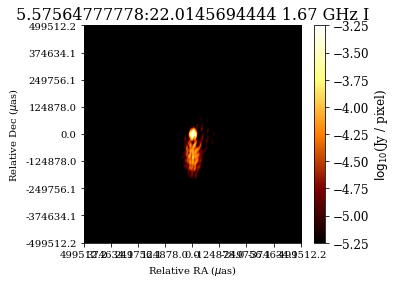

Producing clean visibilities from image with fast FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 


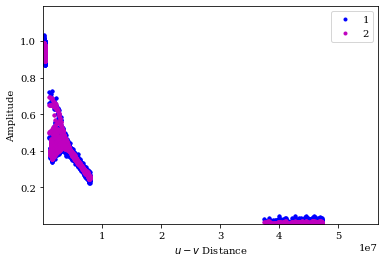

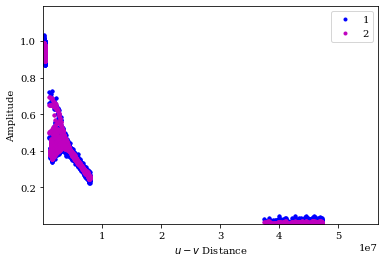

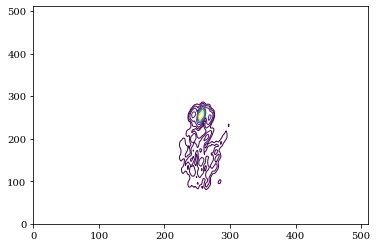

In [10]:
solver.run(1000)

out = solver.finalize(psf=True)
out.display(scale='log', cbar_lims=[-5.25, -3.25])
solver.plot('fit')
solver.display()